N.B: To run this notebook, [McXtrace](https://www.mcxtrace.org/) needs to be installed. Some python libraries are also required such as [McStasScript](https://github.com/PaNOSC-ViNYL/McStasScript), [NumPy](https://numpy.org/), [SciPy](https://scipy.org/) and [matplotlib](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html).

# Summary

Scientists need to know where glitches occur to explain the sharp dips in intensity they observe in their results. In EXAFS measurements for example some glitches disappear due to ratio-ing out but not all do. By knowing where the glitches appear they can confirm that is, or is not, what they see in their results.  
Another possible use is to decide before the experiment is done the most suitable range of energy to use in order to avoid the maximum amount of glitches.  

In order to have this information one can refer to experimental data, such as the data found on SOLEIL's ROCK beamline, or to simulated data.

The work explained here concerns the latter, the Monte-Carlo x-ray simulation software McXtrace is used to find these glitches. The aim is to have a general purpose glitch "finder" or glitch "runner". 

To verify the validity of the simulation the results are compared with the experimental data of the ROCK beamline.

Some python code that finds the positions of glitches is also used as a base of comparison. In the following text these glitches are called "theory glitches".  

To visualize and summarize the results the ROCK beamline data, the McXtrace data and the "theory glitches" data are plotted.  

When comparing McXtrace and the ROCK beamline data, glitches are found at the same positions for the same crystals and orientations. The McXtrace intensity deviations are (mostly) similar to ROCK's data.  

# Table of contents <a name="toc"></a>
1. [Diffraction glitches](#diffraction_glitches)
1. [Simulations procedure](#simulations_procedure)
    1. [McXtrace simulation](#mcxtrace_simulation)
        1. [ROCK beamline](#rock_beamline) 
        1. [Orienting the (hkl) planes](#orienting_hkl_planes)
        1. [Three types of crystals](#three_types_of_crystals)
    1. [Run McXtrace simulations](#run_mcxtrace_simulations)
        1. [McStasScript](#mcstasscript)
    1. [Theory glitches simulation](#theory_glitches_simulation)
        1. [Si 220](#si_220)
        1. [Si 111 long](#si_111_long)        
        1. [Si 111 short](#si_111_short)        
1. [Results](#results)
    1. [Theory glitches, ROCK and McXtrace data](#theory_rock_mcxtrace_data)
        1. [Plot notebook scan](#plot_notebook_scan)
        1. [Prearranged plots](#prearranged_plots)
1. [Interpretation](#interpretation)
    1. [Problems](#problems)
1. [Resources used](#resources_used) 


# Diffraction glitches <a name="diffraction_glitches"></a> 
[[back to toc]](#toc) 

Glitches occur when, for a specific energy, the Bragg law is respected for multiple (hkl) planes at the same time (2 or more).  


d<sub>1</sub>\*sin(θ<sub>1</sub>) = d<sub>2</sub>\*sin(θ<sub>2</sub>) = ... = d<sub>n</sub>\*sin(θ<sub>n</sub>)

with d<sub>1</sub>, d<sub>2</sub>, ..., d<sub>n</sub> the interplanar spacings and θ<sub>1</sub>, θ<sub>2</sub>, ..., θ<sub>n</sub>  the Bragg angles in a glitch condition.

The primary plane of diffraction is the (hkl) plane that is oriented parallel to the crystal's surface. Due to one or more other planes partly diverting the rays, less rays are reflected off of the primary plane of diffraction.  
The beam signal lowers in intensity in a sharp manner.  

![glitches image](images/glitches_corrige_cropped.png)

# Simulations procedure <a name="simulations_procedure"></a> 
[[back to toc]](#toc)  

## McXtrace simulation <a name="mcxtrace_simulation"></a> 
[[back to toc]](#toc)

### ROCK beamline <a name="rock_beamline"></a>

Information on the ROCK beamline can be found [here](https://www.synchrotron-soleil.fr/en/beamlines/rock). ROCK is a quick-EXAFS beamline dedicated to the study of rapid kinetic processes on nanomaterials used mainly in the field of catalysis and batteries.  
ROCK's source is a bending magnet with a range of 4 to 40 keV and a 1.72 Tesla magnet.    
The ring current used is 0.4 A and the ring electron energy is 2.75 GeV.

ROCK's glitch data was made using it's 3 different crystal channel cut monochromators (Si 111 short, Si 111 long and Si 220) and for different absorption samples.
A three stripe mirror (Pd, Pt and B4C) is used for rejecting harmonics. 


### Orienting the (hkl) planes <a name="orienting_hkl_planes"></a>

#### ROCK's plots

Since the results will be compared with ROCK's beamline data, the monochromators need to be oriented the same way ROCK has them oriented.
The aim is to reproduce the glitches for the three channel cuts.   

In the picture below, the intensity of the monitor placed after the monochromator and before the sample called I0 is plotted as a function of the energy for ROCK's Si 111 short crystals for the material Cu around the K edge. Some error artifacts can be present due to the digitalization process of ROCK's data which was done from images.  

![absorption coefficient plot](images/Si_111_short_cu_k_edge.png)





#### (hkl) orientations

There are three crystal channel cuts for the ROCK beamline (Si 111 short, long and Si 220). In the following, the Si 220 is taken as the showcased example but the process is also applied to the other crystals.    

The [220] hkl vector is normal to the crystal's surface. The two other vectors that make up the direct trihedron are along the [-11-2] and [-111] hkl vectors. The following picture illustrates this: 
![phi 0 and phi 90](images/orientation_crystal_220.png)

In the simulation of McXtrace the (hkl) planes need to be oriented properly.

#### Expressing the coordinates of the unit cell 

Any vector of the unit cell basis B can be expressed in the B<sub>hkl</sub> basis (the B<sub>hkl</sub> basis being the one represented in the above picture).
The [220] hkl vector is positioned along the normal to the crystal's surface, the [-11-2] hkl vector parallel to the crystal's long face and the [-111] hkl vector parallel to the short face.

This is done in order to position ourselves on the B<sub>hkl</sub> basis, and express the unit cell basis B in it.
These coordinates are then written in the McXtrace .instr files in parameters called ax,ay,az, bx,by,bz and cx,cy,cz.

![basis explanation](images/basis_explanation_cropped.png)

The above is done in the following code. 

For this case, the vectors [100], [010] and [001] (the normalized vectors of the unit cell basis B) will give the ax,ay,az, bx,by,bz and cx,cy,cz written in the McXtrace simulation files.  

##### Si 220

In [1]:
import math as m
import numpy as np

############## Returns vectors forming B and B_hkl
def vectors_B_Bhkl(xyz_hkl1,xyz_hkl2,xyz_hkl3):
    ############## Express unit cell basis. The canonical basis B = {e1, e2, e3}.
    e1= np.array([[1,0,0]])
    e2= np.array([[0,1,0]])
    e3= np.array([[0,0,1]])

    ############## Express hkl1 hkl2 hkl3 in unit cell basis. The hkl basis, B_hkl = {hkl1, hkl2, hkl3}.
    hkl1 = np.array([xyz_hkl1])
    hkl1_norm = m.sqrt(np.dot(hkl1.reshape((1,3)),hkl1.reshape((3,1))))
    hkl1 = hkl1/hkl1_norm

    hkl2 = np.array([xyz_hkl2])
    hkl2_norm = m.sqrt(np.dot(hkl2.reshape((1,3)),hkl2.reshape((3,1))))
    hkl2 = hkl2/hkl2_norm

    hkl3 = np.array([xyz_hkl3])
    hkl3_norm = m.sqrt(np.dot(hkl3.reshape((1,3)),hkl3.reshape((3,1))))
    hkl3 = hkl3/hkl3_norm

    return e1,e2,e3,hkl1,hkl2,hkl3

#Input the three hkl vectors forming the B_hkl basis here.
xyz_hkl1 = [-1,1,-2]
xyz_hkl2 = [-1,1,1]
xyz_hkl3 = [2,2,0]

e1,e2,e3,hkl1,hkl2,hkl3 = vectors_B_Bhkl(xyz_hkl1,xyz_hkl2,xyz_hkl3)

############## Change of basis matrix from basis B to B_hkl
def change_of_basis_matrix(e1,e2,e3,hkl1,hkl2,hkl3):
    ############## change-of-basis matrix
    #https://www.youtube.com/watch?v=hVmcRYD1KFQ
    #https://www.youtube.com/watch?v=CNIN7UpyXvo
    mat2 = np.array([[np.dot(e1.reshape((1,3)),hkl1.reshape((3,1)))[0][0], np.dot(e2.reshape((1,3)),hkl1.reshape((3,1)))[0][0], np.dot(e3.reshape((1,3)),hkl1.reshape((3,1)))[0][0]],
                     [np.dot(e1.reshape((1,3)),hkl2.reshape((3,1)))[0][0], np.dot(e2.reshape((1,3)),hkl2.reshape((3,1)))[0][0], np.dot(e3.reshape((1,3)),hkl2.reshape((3,1)))[0][0]],
                     [np.dot(e1.reshape((1,3)),hkl3.reshape((3,1)))[0][0], np.dot(e2.reshape((1,3)),hkl3.reshape((3,1)))[0][0], np.dot(e3.reshape((1,3)),hkl3.reshape((3,1)))[0][0]]])
    return mat2
    
mat2 = change_of_basis_matrix(e1,e2,e3,hkl1,hkl2,hkl3)

############## Express [xyz] vector in unit cell basis.
#[1,0,0] then [0,1,0] then [0,0,1] will be expressed.
def xyz_vector(x,y,z):
    xyz = np.array([[x,y,z]])
    #normalise it
    xyz_norm = m.sqrt(np.dot(xyz.reshape((1,3)),xyz.reshape((3,1))))
    xyz = xyz/xyz_norm
    return xyz

############## [1,0,0] is now expressed in the hkl basis B_hkl
xyz = xyz_vector(1,0,0)
xyz_basis_hkl = np.dot(mat2,xyz.reshape((3,1)))
print("[1,0,0] vector expressed in basis hkl: ", xyz_basis_hkl)

############## [0,1,0] is now expressed in the hkl basis B_hkl
xyz = xyz_vector(0,1,0)
xyz_basis_hkl = np.dot(mat2,xyz.reshape((3,1)))
print("[0,1,0] vector expressed in basis hkl: ", xyz_basis_hkl)

############## [0,0,1] is now expressed in the hkl basis B_hkl
xyz = xyz_vector(0,0,1)
xyz_basis_hkl = np.dot(mat2,xyz.reshape((3,1)))
print("[0,0,1] vector expressed in basis hkl: ", xyz_basis_hkl)

[1,0,0] vector expressed in basis hkl:  [[-0.40824829]
 [-0.57735027]
 [ 0.70710678]]
[0,1,0] vector expressed in basis hkl:  [[0.40824829]
 [0.57735027]
 [0.70710678]]
[0,0,1] vector expressed in basis hkl:  [[-0.81649658]
 [ 0.57735027]
 [ 0.        ]]


##### Si 111 long

The equivalent of the above is done for the Si 111 long channel cut.

In [2]:
import sys
if './modules' not in sys.path:
    sys.path.append('./modules')
import change_basis_module
import numpy as np

#Input the three hkl vectors forming the B_hkl basis here.
#Si_111_long
xyz_hkl1 = [-1,-1,2]
xyz_hkl2 = [1,-1,0]
xyz_hkl3 = [1,1,1]

e1,e2,e3,hkl1,hkl2,hkl3 = change_basis_module.vectors_B_Bhkl(xyz_hkl1,xyz_hkl2,xyz_hkl3)

mat2 = change_basis_module.change_of_basis_matrix(e1,e2,e3,hkl1,hkl2,hkl3)

############## [1,0,0] is now expressed in the hkl basis B_hkl
xyz = change_basis_module.xyz_vector(1,0,0)
xyz_basis_hkl = np.dot(mat2,xyz.reshape((3,1)))
print("[1,0,0] vector expressed in basis hkl: ", xyz_basis_hkl)

############## [0,1,0] is now expressed in the hkl basis B_hkl
xyz = change_basis_module.xyz_vector(0,1,0)
xyz_basis_hkl = np.dot(mat2,xyz.reshape((3,1)))
print("[0,1,0] vector expressed in basis hkl: ", xyz_basis_hkl)

############## [0,0,1] is now expressed in the hkl basis B_hkl
xyz = change_basis_module.xyz_vector(0,0,1)
xyz_basis_hkl = np.dot(mat2,xyz.reshape((3,1)))
print("[0,0,1] vector expressed in basis hkl: ", xyz_basis_hkl)

1 0 0
[1,0,0] vector expressed in basis hkl:  [[-0.40824829]
 [ 0.70710678]
 [ 0.57735027]]
0 1 0
[0,1,0] vector expressed in basis hkl:  [[-0.40824829]
 [-0.70710678]
 [ 0.57735027]]
0 0 1
[0,0,1] vector expressed in basis hkl:  [[0.81649658]
 [0.        ]
 [0.57735027]]


##### Si 111 short

And finally for the Si 111 short channel cut.

In [3]:
import sys
if './modules' not in sys.path:
    sys.path.append('./modules')
import change_basis_module
import numpy as np

#Input the three hkl vectors forming the B_hkl basis here.
#Si_111_short
xyz_hkl1 = [-1,2,-1]
xyz_hkl2 = [-1,0,1]
xyz_hkl3 = [1,1,1]

e1,e2,e3,hkl1,hkl2,hkl3 = change_basis_module.vectors_B_Bhkl(xyz_hkl1,xyz_hkl2,xyz_hkl3)

mat2 = change_basis_module.change_of_basis_matrix(e1,e2,e3,hkl1,hkl2,hkl3)

############## [1,0,0] is now expressed in the hkl basis B_hkl
xyz = change_basis_module.xyz_vector(1,0,0)
xyz_basis_hkl = np.dot(mat2,xyz.reshape((3,1)))
print("[1,0,0] vector expressed in basis hkl: ", xyz_basis_hkl)

############## [0,1,0] is now expressed in the hkl basis B_hkl
xyz = change_basis_module.xyz_vector(0,1,0)
xyz_basis_hkl = np.dot(mat2,xyz.reshape((3,1)))
print("[0,1,0] vector expressed in basis hkl: ", xyz_basis_hkl)

############## [0,0,1] is now expressed in the hkl basis B_hkl
xyz = change_basis_module.xyz_vector(0,0,1)
xyz_basis_hkl = np.dot(mat2,xyz.reshape((3,1)))
print("[0,0,1] vector expressed in basis hkl: ", xyz_basis_hkl)

1 0 0
[1,0,0] vector expressed in basis hkl:  [[-0.40824829]
 [-0.70710678]
 [ 0.57735027]]
0 1 0
[0,1,0] vector expressed in basis hkl:  [[0.81649658]
 [0.        ]
 [0.57735027]]
0 0 1
[0,0,1] vector expressed in basis hkl:  [[-0.40824829]
 [ 0.70710678]
 [ 0.57735027]]


### Three types of crystals <a name="three_types_of_crystals"></a>

The simulations are run for three types of crystals: a long Si 111 crystal, a short Si 111 and an Si 220. ROCK uses different crystals for different ranges of energies.


#### Three stripe mirror for harmonic rejection

The source has a dE=18 keV and is centered at E=22 keV, the range is therefore from 4 to 40 keV. A mirror with different coatings is used for different energy ranges to reject harmonics.


![discontinuities](images/reflectivities.png)  


Plotted is the reflectivity as a function of the energy for the beam hitting the mirror at an angle of 4mrad and for three different materials coating the mirror: Palladium, Platinum and Boron carbide.  
The python scripts that made the above plot can be found [here](https://gitlab.synchrotron-soleil.fr/grades/mcxtrace-rock/-/tree/main/ROCK/scripts/reflectivities/energies).

## Run McXtrace simulations  <a name="run_mcxtrace_simulations"></a> 
[[back to toc]](#toc) 

### McStasScript  <a name="mcstasscript"></a> 

[McStasScript](https://github.com/PaNOSC-ViNYL/McStasScript) is an API for creating and running McStas/McXtrace instruments from python scripting.  
It will be used in this notebook to create and run the McXtrace instruments.  
It is also possible to run these instruments independently from McStasScript.  
Two different instruments will be used:
- an instrument for the Si 220 channel cut
- an instrument for the Si 111 channel cut (long and short)

#### Si 220 
##### Creation of the instrument 

A choice can be made between using the conventional white source (4-40 keV) or using a narrower source that speeds up the simulation's runtime and improves the beam's intensity data collected by the monitors.  

In [4]:
import mcstasscript as ms
import sys
if './modules' not in sys.path:
    sys.path.append('./modules')
import monkey_patch_module

#monkey patch to avoid a mcstasscript print that when left clutters the notebook
ms.data.data.McStasMetaData.extract_info = monkey_patch_module.extract_info

my_instrument = ms.McXtrace_instr("mcstasscript_soleil_rock_220",input_path="./running_mcxtrace/mcxtrace_rock_220")

############## Parameters of the instrument
dict_params = {}
dict_params["Etohit"] = 15918
dict_params["scan"] = 0
dict_params["angle_m2a_m2b"] = 0.008
dict_params["nbsample"] = 1
dict_params["sample_density"] = 8.96
dict_params["sample_density_2"] = 10.28

my_instrument.add_parameter("Etohit")
my_instrument.add_parameter("scan")
my_instrument.add_parameter("angle_m2a_m2b")
my_instrument.add_parameter("nbsample")
my_instrument.add_parameter("sample_density")
my_instrument.add_parameter("sample_density_2")

my_instrument.set_parameters(dict_params)

my_instrument.add_parameter("string", "sample_file", value="\"Cu.txt\"")
my_instrument.add_parameter("string", "sample_file_2", value="\"Mo.txt\"")
my_instrument.add_parameter("string", "reflec_material_M1", value="\"Ir.dat\"")
my_instrument.add_parameter("string", "reflec_material_M2A_M2B", value="\"B4C.dat\"")

my_instrument.add_declare_var("double", "dE")
my_instrument.add_declare_var("double", "AngleMonochromator")
my_instrument.add_declare_var("double", "calculated_angle")
my_instrument.add_declare_var("double", "Etohitkev")
my_instrument.add_declare_var("double", "Eminkev")
my_instrument.add_declare_var("double", "Emaxkev")
my_instrument.add_declare_var("double", "incr")
my_instrument.add_declare_var("int", "n")
my_instrument.add_declare_var("int", "i_h")
my_instrument.add_declare_var("int", "i_k")
my_instrument.add_declare_var("int", "i_l")
my_instrument.add_declare_var("double", "length_first_crystal")
my_instrument.add_declare_var("double", "length_second_crystal")
my_instrument.add_declare_var("double", "center_first_crystal")
my_instrument.add_declare_var("double", "dist_center_to_center")
my_instrument.add_declare_var("double", "center_to_c_mono_angle")
my_instrument.add_declare_var("char", "e_repartition_options[512]")
my_instrument.add_declare_var("double", "I_err_calc")
my_instrument.add_declare_var("double", "absorption_coefficient")
my_instrument.add_declare_var("double", "absorption_coefficient_error")
my_instrument.add_declare_var("double", "number_events_after_sample")
my_instrument.add_declare_var("double", "cc_ax")
my_instrument.add_declare_var("double", "cc_ay")
my_instrument.add_declare_var("double", "cc_az")
my_instrument.add_declare_var("double", "cc_bx")
my_instrument.add_declare_var("double", "cc_by")
my_instrument.add_declare_var("double", "cc_bz")
my_instrument.add_declare_var("double", "cc_cx")
my_instrument.add_declare_var("double", "cc_cy")
my_instrument.add_declare_var("double", "cc_cz")
    
initialize_append = """i_h=1;
    i_k=1;
    i_l=1;
    
    Eminkev=5.62883;
    Emaxkev=46.2834;
    incr=0.995/(Emaxkev-Eminkev);
    n=8;
    i_h=2;
    i_k=2;
    i_l=0;
    length_first_crystal=70e-3;
    length_second_crystal=70e-3;
    center_first_crystal=20;
    dist_center_to_center = sqrt(0.01*0.01+0.07*0.07);
    /// center_to_c_mono_angle is arctan(e/(length_first_crystal/2 + length_second_crystal/2))
    center_to_c_mono_angle=0.14189;
    cc_ax = -5.43096*0.40824829;
    cc_ay = -5.43096*0.57735027;
    cc_az = 5.43096*0.70710678;
    cc_bx = 5.43096*0.40824829;
    cc_by = 5.43096*0.57735027;
    cc_bz = 5.43096*0.70710678;
    cc_cx = -5.43096*0.81649658;
    cc_cy = 5.43096*0.57735027;
    cc_cz = 5.43096*0; 

    calculated_angle=RAD2DEG*asin(12398.42*sqrt(n)/(2*5.4309*Etohit));
    Etohitkev=Etohit*(1/1e3);
    fprintf(stdout,\"Energie %g / Angle %g\", Etohitkev, calculated_angle);

    if(Etohitkev<=7.98){
        reflec_material_M2A_M2B=\"B4C.dat\";
    }
    else if (Etohitkev<=16.46){
        reflec_material_M2A_M2B=\"Pd.dat\";
    }
    else if (Etohitkev>16.46){
        reflec_material_M2A_M2B=\"Pt.dat\";
    }

    sprintf(e_repartition_options,\"energy  bins=500 limits=[%g %g],  y  bins=500\",
        Etohitkev-0.02*Etohitkev, Etohitkev+0.02*Etohitkev);"""  

my_instrument.append_initialize(initialize_append)

############## Add all the components
my_origin = my_instrument.add_component("Origin", "Progress_bar", AT=[0,0,0])

# Ask if the white source(4 to 40 keV) or monochromatic source(narrow bandwith of dE=1eV) is to be used
source_choice = int(input("(choice:0)White source(4-40 keV) or (choice:1)monochromatic source(narrow bandwith of dE=1eV):"))

# -------------------------------------------------- Source 
my_source = my_instrument.add_component("Source", "Bending_magnet", AT=[0,0,0], RELATIVE="Origin")
if(source_choice==0):
    my_source.E0 = 22
    my_source.dE = 18
else:
    #my_source.E0 = dict_params["Etohit"]/1000.0
    my_source.E0 = "Etohit/1000.0"
    my_source.dE = 0.001
my_source.Ee = 2.75
my_source.B = 1.72

# -------------------------------------------------- Vertical slit 1 
my_slit1 = my_instrument.add_component("slit1", "Slit", AT=[0,0,8.5336], RELATIVE="PREVIOUS")
my_slit1.xwidth = 0.021
my_slit1.yheight = 0.042

# -------------------------------------------------- Horizontal slit 2
my_slit2 = my_instrument.add_component("slit2", "Slit", AT=[0,0,8.6486-8.5336], RELATIVE="PREVIOUS")
my_slit2.xwidth = 0.02
my_slit2.yheight = 0.01

# -------------------------------------------------- Toroidal mirror M1   
my_mirror_m1 = my_instrument.add_component("mirror_m1", "Mirror_toroid_pothole", AT=[0,0,10.15-8.6486], AT_RELATIVE="PREVIOUS", ROTATED=["-0.0045*RAD2DEG/2", 0, 0], ROTATED_RELATIVE="PREVIOUS")
my_mirror_m1.xwidth = 0.015
my_mirror_m1.zdepth = 1.1
my_mirror_m1.radius = 0.0317
my_mirror_m1.radius_o = 9.02e3
my_mirror_m1.reflec = "reflec_material_M1"
my_mirror_m1.append_EXTEND("if(!SCATTERED) ABSORB;")

my_arm_m1 = my_instrument.add_component("arm_m1", "Arm", AT=[0,0,0], AT_RELATIVE="PREVIOUS", ROTATED=["-0.0045*RAD2DEG", 0, 0], ROTATED_RELATIVE="Source")

# -------------------------------------------------- Horizontal slit  3
my_slit3 = my_instrument.add_component("slit3", "Slit", AT=[0,0,11.6905-10.15], RELATIVE="PREVIOUS")
my_slit3.xwidth = 0.02
my_slit3.yheight = 0.01

# -------------------------------------------------- M2a mirror
my_mirror_m2a = my_instrument.add_component("mirror_m2a", "Mirror", AT=[0,0,16.82-11.6905], AT_RELATIVE="PREVIOUS", ROTATED=["-angle_m2a_m2b*RAD2DEG/2", 0, 0], ROTATED_RELATIVE="PREVIOUS")
my_mirror_m2a.xwidth = 47e-3
my_mirror_m2a.zdepth = 1100e-3
my_mirror_m2a.reflectivity = "reflec_material_M2A_M2B"
my_mirror_m2a.append_EXTEND("if(!SCATTERED) ABSORB;")

my_arm_m2a = my_instrument.add_component("arm_m2a", "Arm", AT=[0,0,0], AT_RELATIVE="PREVIOUS", ROTATED=["-angle_m2a_m2b*RAD2DEG/2", 0, 0], ROTATED_RELATIVE="PREVIOUS")

# -------------------------------------------------- Horizontal slit 4
my_slit4 = my_instrument.add_component("slit4", "Slit", AT=[0,0,18.1512-16.82], RELATIVE="PREVIOUS")
my_slit4.xwidth = 0.02
my_slit4.yheight = 0.01

my_mono_loc = my_instrument.add_component("mono_loc", "Arm", AT=[0,0,"center_first_crystal-18.1512"], RELATIVE="PREVIOUS")

# -------------------------------------------------------------------------- CC Si 220 with an energy range of  5628.83-46283.4 eV/4-35 deg (hittable:11752-34055 ev/5.44-15.94 deg). 
# -------------------------------------------------------------------------- Double crystal monochromator
my_mono_rotation = my_instrument.add_component("mono_rotation", "Arm", AT=[0,0,0], AT_RELATIVE="mono_loc", ROTATED=[-90, 0, 0], ROTATED_RELATIVE="mono_loc") 
#y looking at the incoming beam, x looking to the left! 

#this is done so we have the same orientation as ssrl for the cc 220
my_mono_rotation_phi_90 = my_instrument.add_component("mono_rotation_phi_90", "Arm", AT=[0,0,0], AT_RELATIVE="PREVIOUS", ROTATED=[0,0,-90], ROTATED_RELATIVE="PREVIOUS") 

my_mono_rotation_bragg_angle = my_instrument.add_component("mono_rotation_bragg_angle", "Arm", AT=[0,0,0], AT_RELATIVE="PREVIOUS", ROTATED=[0,"-calculated_angle",0], ROTATED_RELATIVE="PREVIOUS") 
#-x looking at the incoming beam, y looking to the left!

# -------------------------------------------------- CC crystal 1
my_bragg_crystal = my_instrument.add_component("bragg_crystal", "Single_crystal", AT=[0, 0, 0], AT_RELATIVE="PREVIOUS",ROTATED=[0,0,0], ROTATED_RELATIVE="PREVIOUS")
my_bragg_crystal.reflections = "\"Si.lau\""
my_bragg_crystal.material = "\"Si.txt\""
my_bragg_crystal.xwidth = "length_first_crystal" 
my_bragg_crystal.yheight =  25e-3
my_bragg_crystal.zdepth = 0.001
my_bragg_crystal.p_transmit = -1
my_bragg_crystal.order = 1
my_bragg_crystal.mosaic = 1
my_bragg_crystal.barns = 1
my_bragg_crystal.ax = "cc_ax"
my_bragg_crystal.ay = "cc_ay"
my_bragg_crystal.az = "cc_az"
my_bragg_crystal.bx = "cc_bx"
my_bragg_crystal.by = "cc_by"
my_bragg_crystal.bz = "cc_bz"
my_bragg_crystal.cx = "cc_cx"
my_bragg_crystal.cy = "cc_cy"
my_bragg_crystal.cz = "cc_cz"
my_bragg_crystal.append_EXTEND("if(!SCATTERED) ABSORB;")

my_arm_crystal1 = my_instrument.add_component("arm_crystal1", "Arm",  AT=[0, 0, 0], AT_RELATIVE="PREVIOUS",ROTATED=[0, "-calculated_angle", 0], ROTATED_RELATIVE="PREVIOUS")

# -------------------------------------------------- CC crystal 2
my_bragg_crystal_two = my_instrument.copy_component("bragg_crystal_two", "bragg_crystal", AT=["(length_first_crystal/2)+(length_second_crystal/2)", 0, 0.01+0.001], AT_RELATIVE="bragg_crystal",ROTATED=[0, "calculated_angle", 0], ROTATED_RELATIVE="PREVIOUS")
my_bragg_crystal_two.yheight = "length_second_crystal"
my_bragg_crystal_two.append_EXTEND("if(!SCATTERED) ABSORB;")

my_arm_crystal2 = my_instrument.add_component("arm_crystal2", "Arm",  AT=[0, 0, 0], AT_RELATIVE="PREVIOUS",ROTATED=[0, "calculated_angle", 0], ROTATED_RELATIVE="PREVIOUS")

my_mono_rotation_undo_phi_90 = my_instrument.add_component("mono_rotation_undo_phi_90", "Arm",  AT=[0, 0, 0], AT_RELATIVE="PREVIOUS",ROTATED=[0,0,90], ROTATED_RELATIVE="PREVIOUS") #undo it

my_mono_rotation_undo = my_instrument.add_component("mono_rotation_undo", "Arm",  AT=[0, 0, 0], AT_RELATIVE="PREVIOUS",ROTATED=[90,0,0], ROTATED_RELATIVE="PREVIOUS") #undo it

# -------------------------------------------------- Horizontal slit 5 
my_slit5 = my_instrument.add_component("slit5", "Slit", AT=[0, "(0.01*2*cos(DEG2RAD*calculated_angle)-dist_center_to_center*sin(center_to_c_mono_angle+DEG2RAD*calculated_angle))", "(21.135-(center_first_crystal+cos(0.0045+angle_m2a_m2b+DEG2RAD*calculated_angle*2)*dist_center_to_center))/cos(0.0045+angle_m2a_m2b)"], RELATIVE="PREVIOUS")
my_slit5.xwidth = 0.02
my_slit5.yheight = 0.01

my_slit6 = my_instrument.add_component("slit6", "Slit", AT=[0, 0, 21.25-21.135], RELATIVE="PREVIOUS")
my_slit6.xwidth = 0.01
my_slit6.yheight = 0.02

# -------------------------------------------------- M2b mirror    
my_mirror_m2b = my_instrument.add_component("mirror_m2b", "Mirror_curved", AT=[0, 0, 22.44-21.25], AT_RELATIVE="PREVIOUS", ROTATED=["angle_m2a_m2b*RAD2DEG/2", 0, 90], ROTATED_RELATIVE="PREVIOUS")
my_mirror_m2b.radius = 5e3
my_mirror_m2b.width = 47e-3
my_mirror_m2b.length = 1100e-3
my_mirror_m2b.coating = "reflec_material_M2A_M2B"
my_mirror_m2b.append_EXTEND("if(!SCATTERED) ABSORB;")

my_arm_m2b = my_instrument.add_component("arm_m2b", "Arm", AT=[0,0,0], AT_RELATIVE="PREVIOUS", ROTATED=["angle_m2a_m2b*RAD2DEG", 0, 0], ROTATED_RELATIVE="mono_rotation_undo")

# -------------------------------------------------- E monitor 
my_EnergyMonitor_before_sample = my_instrument.add_component("EnergyMonitor_before_sample", "Monitor_nD", AT=[0,0,10], RELATIVE="PREVIOUS")
my_EnergyMonitor_before_sample.xmin = -2
my_EnergyMonitor_before_sample.xmax = 2
my_EnergyMonitor_before_sample.ymin = -2
my_EnergyMonitor_before_sample.ymax =  2
my_EnergyMonitor_before_sample.min = "Etohitkev-(0.005+(Etohitkev-Eminkev)*incr)"
my_EnergyMonitor_before_sample.max = "Etohitkev+(0.005+(Etohitkev-Eminkev)*incr)"
my_EnergyMonitor_before_sample.bins = 500
my_EnergyMonitor_before_sample.options = "\"energy\""
my_EnergyMonitor_before_sample.filename = "\"EnergyMonitor_before_sample\""
my_EnergyMonitor_before_sample.restore_xray = 1

my_e_repartition_after_m2b = my_instrument.add_component("e_repartition_after_m2b", "Monitor_nD", AT=[0,0,0], RELATIVE="PREVIOUS")
my_e_repartition_after_m2b.xmin = -0.01
my_e_repartition_after_m2b.xmax = 0.01
my_e_repartition_after_m2b.ymin = -0.01
my_e_repartition_after_m2b.ymax =  0.01
my_e_repartition_after_m2b.options = "e_repartition_options"
my_e_repartition_after_m2b.filename = "\"e_repartition_after_m2b\""
my_e_repartition_after_m2b.restore_xray = 1

# -------------------------------------------------- sample 
my_absorption_sample = my_instrument.add_component("absorption_sample", "Absorption_sample", AT=[0,0,0.5], RELATIVE="e_repartition_after_m2b")
my_absorption_sample.material_datafile_o = "sample_file"
my_absorption_sample.xwidth_o = 0.5
my_absorption_sample.yheight_o = 0.5
my_absorption_sample.zdepth_o = 0.0001
my_absorption_sample.rho_o = "sample_density"
my_absorption_sample.set_WHEN("nbsample==1")

my_absorption_sample_2 = my_instrument.add_component("my_absorption_sample_2", "Absorption_sample", AT=[0,0,0.5], RELATIVE="e_repartition_after_m2b")
my_absorption_sample_2.material_datafile_o = "sample_file"
my_absorption_sample_2.xwidth_o = 0.5
my_absorption_sample_2.yheight_o = 0.5
my_absorption_sample_2.zdepth_o = 0.0001
my_absorption_sample_2.rho_o = "sample_density"
my_absorption_sample_2.rho_i = "sample_density_2"
my_absorption_sample_2.material_datafile_i = "sample_file_2"
my_absorption_sample_2.xwidth_i = 0.5
my_absorption_sample_2.yheight_i = 0.5
my_absorption_sample_2.zdepth_i = 0.00005
my_absorption_sample_2.set_WHEN("nbsample==2")

# -------------------------------------------------- E monitor 
my_EnergyMonitor_after_sample = my_instrument.copy_component("EnergyMonitor_after_sample", "EnergyMonitor_before_sample", AT=[0,0,0.5], RELATIVE="PREVIOUS")
my_EnergyMonitor_after_sample.filename = "\"EnergyMonitor_after_sample\""

my_psd_monitor = my_instrument.add_component("psd_monitor", "PSD_monitor", AT=[0,0,0], RELATIVE="PREVIOUS")
my_psd_monitor.xmin = -0.002
my_psd_monitor.xmax = 0.002
my_psd_monitor.ymin = -0.01
my_psd_monitor.ymax =  0.01
my_psd_monitor.filename = "\"psd\""
my_psd_monitor.nx = 100
my_psd_monitor.ny = 100
my_psd_monitor.restore_xray = 1

############## Add the calculated monitor (absorption coefficient)
finally_append = """// If there is a scan, calculate the absorption coefficient.
    if(scan>=1){ 
#ifdef USE_MPI
        //MPI_MASTER is equivalent to if(mpi_node_root>=mpi_node_rank){ //statement }
        //If DETECTOR_OUT_0D is inside of MPI_MASTER the program hangs forever. 
        //If outside it seems to work. Weird.
        MPI_MASTER(
#endif 
        MCDETECTOR e_before_sample = MC_GETPAR(EnergyMonitor_before_sample,detector);
        MCDETECTOR e_after_sample = MC_GETPAR(EnergyMonitor_after_sample,detector);
        absorption_coefficient = log(e_before_sample.intensity/e_after_sample.intensity);              
        I_err_calc = ((e_before_sample.error/e_before_sample.intensity)+(e_after_sample.error/e_after_sample.intensity));                  
        absorption_coefficient_error = I_err_calc;  
        number_events_after_sample = e_after_sample.events; 

        fprintf(stdout,\"*** \\n\");    
        fprintf(stdout,\"Before the sample: I %g I_error %g N %g \\n\", e_before_sample.intensity, e_before_sample.error, e_before_sample.events);
        fprintf(stdout,\"After the sample: I %g I_error %g N %g \\n\", e_after_sample.intensity, e_after_sample.error, e_after_sample.events); 
        fprintf(stdout,\"I_err_calc: I %g \\n\", I_err_calc);
        fprintf(stdout,\"*** \\n \");  
                                                 
#ifdef USE_MPI                  
        );
        //MPI_Barrier(MPI_COMM_WORLD);
#endif  
                      
        // This set of defines is to avoid getting a '.' in the component name
        #ifdef NAME_CURRENT_COMP
        #undef NAME_CURRENT_COMP
        #define NAME_CURRENT_COMP \"absorption_coefficient\"
        #endif           

        DETECTOR_OUT_0D(
                  \"XANES EXAFS\",
                  number_events_after_sample, absorption_coefficient, absorption_coefficient_error);  
    }"""  

my_instrument.append_finally(finally_append)

############## Ask number of cores to use for mpi, 60 by default
try:
    mpi_cores = int(input("Input number of cores to use with mpi (60 by default):"))
except ValueError:
    mpi_cores = 60

my_instrument.settings(output_path="./running_mcxtrace/mcxtrace_rock_220/soleil_rock_220_res", mpi=mpi_cores, ncount=1E6) 

print("Instrument ROCK Si 220 configured.")

(choice:0)White source(4-40 keV) or (choice:1)monochromatic source(narrow bandwith of dE=1eV):0
Input number of cores to use with mpi (60 by default):
Instrument ROCK Si 220 configured.


##### Energy scan 

Chose the energy range to scan for with the channel cut. 

In [5]:
# -------------------------------------------------- Input energy range to scan
print("Full possible range for Si 220: 11752-34055 eV")
energy_initial = int(input("Input initial energy(eV):"))
energy_final = int(input("Input final energy(eV):"))
energy_scan_range = []

egy = energy_initial
while egy<=energy_final:
    energy_scan_range.append(egy)
    egy+=1

data_list = []
dict_params["scan"] = 1

#avoid McXtrace's output to not clutter the notebook
my_instrument.settings(suppress_output=True)

for energy in energy_scan_range:
    dict_params["Etohit"] = energy
 
    #print on the same line       
    try:
        print(len(text_to_print_egy_si220)*' ',end='\r')
    except NameError:
        pass
    text_to_print_egy_si220 = "running simulation for energy: " +str(energy)
    print(text_to_print_egy_si220,end='\r')

    my_instrument.set_parameters(dict_params)
    data = my_instrument.backengine()
    data_list.append(data)
    my_instrument.settings(force_compile=False)
    
my_instrument.settings(force_compile=True)

#writing the equivalent of mccode.dat, getting the total intensity of the 4 monitors
counter = 0
with open('./running_mcxtrace/mcxtrace_rock_220/mccode_mcstasscript_rock_220.dat', 'w') as f:    
    for energy in energy_scan_range:
        f.write(str(energy))
        f.write(" "+data_list[counter][0].metadata.info['values'].split(" ")[0])
        f.write(" "+data_list[counter][1].metadata.info['values'].split(" ")[0])
        f.write(" "+data_list[counter][2].metadata.info['values'].split(" ")[0])
        f.write(" "+data_list[counter][3].metadata.info['values'].split(" ")[0])        
        f.write("\n")    
        counter+=1

print("\nEnergy scan finished")

Full possible range for Si 220: 11752-34055 eV
Input initial energy(eV):13000
Input final energy(eV):13001
running simulation for energy: 13001
Energy scan finished


#### Si 111
##### Creation of the instrument 

In [6]:
import mcstasscript as ms
import sys
if './modules' not in sys.path:
    sys.path.append('./modules')
import monkey_patch_module

#monkey patch to avoid a mcstasscript print that when left clutters the notebook
ms.data.data.McStasMetaData.extract_info = monkey_patch_module.extract_info

my_instrument = ms.McXtrace_instr("mcstasscript_soleil_rock_111",input_path="./running_mcxtrace/mcxtrace_rock_111")

############## Parameters of the instrument
dict_params = {}
dict_params["Etohit"] = 15918
dict_params["scan"] = 0
dict_params["angle_m2a_m2b"] = 0.008
dict_params["nbsample"] = 1
dict_params["sample_density"] = 8.96
dict_params["sample_density_2"] = 10.28
dict_params["cc"] = 1

my_instrument.add_parameter("Etohit")
my_instrument.add_parameter("scan")
my_instrument.add_parameter("angle_m2a_m2b")
my_instrument.add_parameter("nbsample")
my_instrument.add_parameter("sample_density")
my_instrument.add_parameter("sample_density_2")
my_instrument.add_parameter("cc")

my_instrument.set_parameters(dict_params)

my_instrument.add_parameter("string", "sample_file", value="\"Cu.txt\"")
my_instrument.add_parameter("string", "sample_file_2", value="\"Mo.txt\"")
my_instrument.add_parameter("string", "reflec_material_M1", value="\"Ir.dat\"")
my_instrument.add_parameter("string", "reflec_material_M2A_M2B", value="\"B4C.dat\"")

my_instrument.add_declare_var("double", "dE")
my_instrument.add_declare_var("double", "AngleMonochromator")
my_instrument.add_declare_var("double", "calculated_angle")
my_instrument.add_declare_var("double", "Etohitkev")
my_instrument.add_declare_var("double", "Eminkev")
my_instrument.add_declare_var("double", "Emaxkev")
my_instrument.add_declare_var("double", "incr")
my_instrument.add_declare_var("int", "n")
my_instrument.add_declare_var("int", "i_h")
my_instrument.add_declare_var("int", "i_k")
my_instrument.add_declare_var("int", "i_l")
my_instrument.add_declare_var("double", "length_first_crystal")
my_instrument.add_declare_var("double", "length_second_crystal")
my_instrument.add_declare_var("double", "center_first_crystal")
my_instrument.add_declare_var("double", "dist_center_to_center")
my_instrument.add_declare_var("double", "center_to_c_mono_angle")
my_instrument.add_declare_var("char", "e_repartition_options[512]")
my_instrument.add_declare_var("double", "I_err_calc")
my_instrument.add_declare_var("double", "absorption_coefficient")
my_instrument.add_declare_var("double", "absorption_coefficient_error")
my_instrument.add_declare_var("double", "number_events_after_sample")
my_instrument.add_declare_var("double", "cc_ax")
my_instrument.add_declare_var("double", "cc_ay")
my_instrument.add_declare_var("double", "cc_az")
my_instrument.add_declare_var("double", "cc_bx")
my_instrument.add_declare_var("double", "cc_by")
my_instrument.add_declare_var("double", "cc_bz")
my_instrument.add_declare_var("double", "cc_cx")
my_instrument.add_declare_var("double", "cc_cy")
my_instrument.add_declare_var("double", "cc_cz")

initialize_append = """i_h=1;
    i_k=1;
    i_l=1;
    
    if(cc>=3){ //automatically select the right cc for the energy Etohit
        if(Etohit<=15516){ 
            cc = 2;
        }
        else if (Etohit<=17439){
            cc = 1;
        }
    }

    if (cc<=1){ //cc long 111
        Eminkev=3.44694;
        Emaxkev=28.3427;
        incr=0.995/(Emaxkev-Eminkev);
        n=3;
        length_first_crystal=70e-3;
        length_second_crystal=70e-3;
        center_first_crystal=18.92;
        dist_center_to_center = sqrt(0.01*0.01+0.07*0.07);
        center_to_c_mono_angle=0.14189;
        cc_ax = -5.43096*0.40824829;
        cc_ay = 5.43096*0.70710678;
        cc_az = 5.43096*0.57735027;
        cc_bx = -5.43096*0.40824829;
        cc_by = -5.43096*0.70710678;
        cc_bz = 5.43096*0.57735027;
        cc_cx = 5.43096*0.81649658;
        cc_cy = 5.43096*0;
        cc_cz = 5.43096*0.57735027;        
    } else if (cc<=2){ //cc short 111
        Eminkev=3.44694;
        Emaxkev=18.9143;
        incr=0.995/(Emaxkev-Eminkev);
        n=3;
        length_first_crystal=50e-3;
        length_second_crystal=70e-3;
        center_first_crystal=19.25;
        dist_center_to_center = sqrt(0.01*0.01+0.06*0.06);
        center_to_c_mono_angle=0.1651;
        cc_ax = -5.43096*0.40824829;
        cc_ay = -5.43096*0.70710678;
        cc_az = 5.43096*0.57735027;
        cc_bx = 5.43096*0.81649658;
        cc_by = 5.43096*0;
        cc_bz = 5.43096*0.57735027;
        cc_cx = -5.43096*0.40824829;
        cc_cy = 5.43096*0.70710678;
        cc_cz = 5.43096*0.57735027;        
    }

    calculated_angle=RAD2DEG*asin(12398.42*sqrt(n)/(2*5.4309*Etohit));
    Etohitkev=Etohit*(1/1e3);
    fprintf(stdout,\"Energie %g / Angle %g\", Etohitkev, calculated_angle);

    if(Etohitkev<=7.98){
        reflec_material_M2A_M2B=\"B4C.dat\";
    }
    else if (Etohitkev<=16.46){
        reflec_material_M2A_M2B=\"Pd.dat\";
    }
    else if (Etohitkev>16.46){
        reflec_material_M2A_M2B=\"Pt.dat\";
    }

    sprintf(e_repartition_options,\"energy  bins=500 limits=[%g %g],  y  bins=500\",
        Etohitkev-0.02*Etohitkev, Etohitkev+0.02*Etohitkev);"""  

my_instrument.append_initialize(initialize_append)

############## Add all the components
my_origin = my_instrument.add_component("Origin", "Progress_bar", AT=[0,0,0])

#Ask if the white source(4 to 40 keV) or monochromatic source(narrow bandwith of dE=1eV) is to be used
source_choice = int(input("(choice:0)White source(4-40 keV) or (choice:1)monochromatic source(narrow bandwith of dE=1eV):"))

# -------------------------------------------------- Source 
my_source = my_instrument.add_component("Source", "Bending_magnet", AT=[0,0,0], RELATIVE="Origin")
if(source_choice==0):
    my_source.E0 = 22
    my_source.dE = 18
else:
    #my_source.E0 = dict_params["Etohit"]/1000.0
    my_source.E0 = "Etohit/1000.0"
    my_source.dE = 0.001   
my_source.Ee = 2.75
my_source.B = 1.72

# -------------------------------------------------- Vertical slit 1 
my_slit1 = my_instrument.add_component("slit1", "Slit", AT=[0,0,8.5336], RELATIVE="PREVIOUS")
my_slit1.xwidth = 0.021
my_slit1.yheight = 0.042

# -------------------------------------------------- Horizontal slit 2
my_slit2 = my_instrument.add_component("slit2", "Slit", AT=[0,0,8.6486-8.5336], RELATIVE="PREVIOUS")
my_slit2.xwidth = 0.02
my_slit2.yheight = 0.01

# -------------------------------------------------- Toroidal mirror M1   
my_mirror_m1 = my_instrument.add_component("mirror_m1", "Mirror_toroid_pothole", AT=[0,0,10.15-8.6486], AT_RELATIVE="PREVIOUS", ROTATED=["-0.0045*RAD2DEG/2", 0, 0], ROTATED_RELATIVE="PREVIOUS")
my_mirror_m1.xwidth = 0.015
my_mirror_m1.zdepth = 1.1
my_mirror_m1.radius = 0.0317
my_mirror_m1.radius_o = 9.02e3
my_mirror_m1.reflec = "reflec_material_M1"
my_mirror_m1.append_EXTEND("if(!SCATTERED) ABSORB;")

my_arm_m1 = my_instrument.add_component("arm_m1", "Arm", AT=[0,0,0], AT_RELATIVE="PREVIOUS", ROTATED=["-0.0045*RAD2DEG", 0, 0], ROTATED_RELATIVE="Source")

# -------------------------------------------------- Horizontal slit  3
my_slit3 = my_instrument.add_component("slit3", "Slit", AT=[0,0,11.6905-10.15], RELATIVE="PREVIOUS")
my_slit3.xwidth = 0.02
my_slit3.yheight = 0.01

# -------------------------------------------------- M2a mirror
my_mirror_m2a = my_instrument.add_component("mirror_m2a", "Mirror", AT=[0,0,16.82-11.6905], AT_RELATIVE="PREVIOUS", ROTATED=["-angle_m2a_m2b*RAD2DEG/2", 0, 0], ROTATED_RELATIVE="PREVIOUS")
my_mirror_m2a.xwidth = 47e-3
my_mirror_m2a.zdepth = 1100e-3
my_mirror_m2a.reflectivity = "reflec_material_M2A_M2B"
my_mirror_m2a.append_EXTEND("if(!SCATTERED) ABSORB;")

my_arm_m2a = my_instrument.add_component("arm_m2a", "Arm", AT=[0,0,0], AT_RELATIVE="PREVIOUS", ROTATED=["-angle_m2a_m2b*RAD2DEG/2", 0, 0], ROTATED_RELATIVE="PREVIOUS")

# -------------------------------------------------- Horizontal slit 4
my_slit4 = my_instrument.add_component("slit4", "Slit", AT=[0,0,18.1512-16.82], RELATIVE="PREVIOUS")
my_slit4.xwidth = 0.02
my_slit4.yheight = 0.01

my_mono_loc = my_instrument.add_component("mono_loc", "Arm", AT=[0,0,"center_first_crystal-18.1512"], RELATIVE="PREVIOUS")

# -------------------------------------------------------------------------- Double crystal monochromator
my_mono_rotation = my_instrument.add_component("mono_rotation", "Arm", AT=[0,0,0], AT_RELATIVE="mono_loc", ROTATED=[-90, 0, 0], ROTATED_RELATIVE="mono_loc") 
#y looking at the incoming beam, x looking to the left!

my_mono_rotation_bragg_angle = my_instrument.add_component("mono_rotation_bragg_angle", "Arm", AT=[0,0,0], AT_RELATIVE="PREVIOUS", ROTATED=["-calculated_angle", 0, 0], ROTATED_RELATIVE="PREVIOUS") 
#y looking at the incoming beam, x looking to the left!

# -------------------------------------------------- CC crystal 1
my_bragg_crystal = my_instrument.add_component("bragg_crystal", "Single_crystal", AT=[0, 0, 0], AT_RELATIVE="PREVIOUS",ROTATED=[0,0,0], ROTATED_RELATIVE="PREVIOUS")
my_bragg_crystal.reflections = "\"Si.lau\""
my_bragg_crystal.material = "\"Si.txt\""
my_bragg_crystal.xwidth = 25e-3
my_bragg_crystal.yheight =  "length_first_crystal"
my_bragg_crystal.zdepth = 0.001
my_bragg_crystal.p_transmit = -1
my_bragg_crystal.order = 1
my_bragg_crystal.mosaic = 1
my_bragg_crystal.barns = 1
my_bragg_crystal.ax = "cc_ax"
my_bragg_crystal.ay = "cc_ay"
my_bragg_crystal.az = "cc_az"
my_bragg_crystal.bx = "cc_bx"
my_bragg_crystal.by = "cc_by"
my_bragg_crystal.bz = "cc_bz"
my_bragg_crystal.cx = "cc_cx"
my_bragg_crystal.cy = "cc_cy"
my_bragg_crystal.cz = "cc_cz"
my_bragg_crystal.append_EXTEND("if(!SCATTERED) ABSORB;")

my_arm_crystal1 = my_instrument.add_component("arm_crystal1", "Arm",  AT=[0, 0, 0], AT_RELATIVE="PREVIOUS",ROTATED=["-calculated_angle",0,0], ROTATED_RELATIVE="PREVIOUS")

# -------------------------------------------------- CC crystal 2
my_bragg_crystal_two = my_instrument.copy_component("my_bragg_crystal_two", "bragg_crystal", AT=[0, "-((length_first_crystal/2)+(length_second_crystal/2))", 0.01+0.001], AT_RELATIVE="bragg_crystal",ROTATED=["calculated_angle",0,0], ROTATED_RELATIVE="PREVIOUS")
my_bragg_crystal_two.yheight = "length_second_crystal"
my_bragg_crystal_two.append_EXTEND("if(!SCATTERED) ABSORB;")

my_arm_crystal2 = my_instrument.add_component("arm_crystal2", "Arm",  AT=[0, 0, 0], AT_RELATIVE="PREVIOUS",ROTATED=["calculated_angle",0,0], ROTATED_RELATIVE="PREVIOUS")

my_mono_rotation_undo = my_instrument.add_component("mono_rotation_undo", "Arm",  AT=[0, 0, 0], AT_RELATIVE="PREVIOUS",ROTATED=[90,0,0], ROTATED_RELATIVE="PREVIOUS") #undo it

# -------------------------------------------------- Horizontal slit 5 
my_slit5 = my_instrument.add_component("slit5", "Slit", AT=[0, "(0.01*2*cos(DEG2RAD*calculated_angle)-dist_center_to_center*sin(center_to_c_mono_angle+DEG2RAD*calculated_angle))", "(21.135-(center_first_crystal+cos(0.0045+angle_m2a_m2b+DEG2RAD*calculated_angle*2)*dist_center_to_center))/cos(0.0045+angle_m2a_m2b)"], RELATIVE="PREVIOUS")
my_slit5.xwidth = 0.02
my_slit5.yheight = 0.01

my_slit6 = my_instrument.add_component("slit6", "Slit", AT=[0, 0, 21.25-21.135], RELATIVE="PREVIOUS")
my_slit6.xwidth = 0.01
my_slit6.yheight = 0.02

# -------------------------------------------------- M2b mirror    
my_mirror_m2b = my_instrument.add_component("mirror_m2b", "Mirror_curved", AT=[0, 0, 22.44-21.25], AT_RELATIVE="PREVIOUS", ROTATED=["angle_m2a_m2b*RAD2DEG/2", 0, 90], ROTATED_RELATIVE="PREVIOUS")
my_mirror_m2b.radius = 5e3
my_mirror_m2b.width = 47e-3
my_mirror_m2b.length = 1100e-3
my_mirror_m2b.coating = "reflec_material_M2A_M2B"
my_mirror_m2b.append_EXTEND("if(!SCATTERED) ABSORB;")

my_arm_m2b = my_instrument.add_component("arm_m2b", "Arm", AT=[0,0,0], AT_RELATIVE="PREVIOUS", ROTATED=["angle_m2a_m2b*RAD2DEG", 0, 0], ROTATED_RELATIVE="mono_rotation_undo")

# -------------------------------------------------- E monitor 
my_EnergyMonitor_before_sample = my_instrument.add_component("EnergyMonitor_before_sample", "Monitor_nD", AT=[0,0,10], RELATIVE="PREVIOUS")
my_EnergyMonitor_before_sample.xmin = -2
my_EnergyMonitor_before_sample.xmax = 2
my_EnergyMonitor_before_sample.ymin = -2
my_EnergyMonitor_before_sample.ymax =  2
my_EnergyMonitor_before_sample.min = "Etohitkev-(0.005+(Etohitkev-Eminkev)*incr)"
my_EnergyMonitor_before_sample.max = "Etohitkev+(0.005+(Etohitkev-Eminkev)*incr)"
my_EnergyMonitor_before_sample.bins = 500
my_EnergyMonitor_before_sample.options = "\"energy\""
my_EnergyMonitor_before_sample.filename = "\"EnergyMonitor_before_sample\""
my_EnergyMonitor_before_sample.restore_xray = 1

my_e_repartition_after_m2b = my_instrument.add_component("e_repartition_after_m2b", "Monitor_nD", AT=[0,0,0], RELATIVE="PREVIOUS")
my_e_repartition_after_m2b.xmin = -0.01
my_e_repartition_after_m2b.xmax = 0.01
my_e_repartition_after_m2b.ymin = -0.01
my_e_repartition_after_m2b.ymax =  0.01
my_e_repartition_after_m2b.options = "e_repartition_options"
my_e_repartition_after_m2b.filename = "\"e_repartition_after_m2b\""
my_e_repartition_after_m2b.restore_xray = 1

# -------------------------------------------------- sample 
my_absorption_sample = my_instrument.add_component("absorption_sample", "Absorption_sample", AT=[0,0,0.5], RELATIVE="e_repartition_after_m2b")
my_absorption_sample.material_datafile_o = "sample_file"
my_absorption_sample.xwidth_o = 0.5
my_absorption_sample.yheight_o = 0.5
my_absorption_sample.zdepth_o = 0.0001
my_absorption_sample.rho_o = "sample_density"
my_absorption_sample.set_WHEN("nbsample==1")

my_absorption_sample_2 = my_instrument.add_component("my_absorption_sample_2", "Absorption_sample", AT=[0,0,0.5], RELATIVE="e_repartition_after_m2b")
my_absorption_sample_2.material_datafile_o = "sample_file"
my_absorption_sample_2.xwidth_o = 0.5
my_absorption_sample_2.yheight_o = 0.5
my_absorption_sample_2.zdepth_o = 0.0001
my_absorption_sample_2.rho_o = "sample_density"
my_absorption_sample_2.rho_i = "sample_density_2"
my_absorption_sample_2.material_datafile_i = "sample_file_2"
my_absorption_sample_2.xwidth_i = 0.5
my_absorption_sample_2.yheight_i = 0.5
my_absorption_sample_2.zdepth_i = 0.00005
my_absorption_sample_2.set_WHEN("nbsample==2")

# -------------------------------------------------- E monitor 
my_EnergyMonitor_after_sample = my_instrument.copy_component("EnergyMonitor_after_sample", "EnergyMonitor_before_sample", AT=[0,0,0.5], RELATIVE="PREVIOUS")
my_EnergyMonitor_after_sample.filename = "\"EnergyMonitor_after_sample\""

my_psd_monitor = my_instrument.add_component("psd_monitor", "PSD_monitor", AT=[0,0,0], RELATIVE="PREVIOUS")
my_psd_monitor.xmin = -0.002
my_psd_monitor.xmax = 0.002
my_psd_monitor.ymin = -0.01
my_psd_monitor.ymax =  0.01
my_psd_monitor.filename = "\"psd\""
my_psd_monitor.nx = 100
my_psd_monitor.ny = 100
my_psd_monitor.restore_xray = 1

############## Add the calculated monitor (absorption coefficient)
finally_append = """// If there is a scan, calculate the absorption coefficient.
    if(scan>=1){ 
#ifdef USE_MPI
        //MPI_MASTER is equivalent to if(mpi_node_root>=mpi_node_rank){ //statement }
        //If DETECTOR_OUT_0D is inside of MPI_MASTER the program hangs forever. 
        //If outside it seems to work. Weird.
        MPI_MASTER(
#endif 
        MCDETECTOR e_before_sample = MC_GETPAR(EnergyMonitor_before_sample,detector);
        MCDETECTOR e_after_sample = MC_GETPAR(EnergyMonitor_after_sample,detector);
        absorption_coefficient = log(e_before_sample.intensity/e_after_sample.intensity);              
        I_err_calc = ((e_before_sample.error/e_before_sample.intensity)+(e_after_sample.error/e_after_sample.intensity));                  
        absorption_coefficient_error = I_err_calc;  
        number_events_after_sample = e_after_sample.events; 

        fprintf(stdout,\"*** \\n\");    
        fprintf(stdout,\"Before the sample: I %g I_error %g N %g \\n\", e_before_sample.intensity, e_before_sample.error, e_before_sample.events);
        fprintf(stdout,\"After the sample: I %g I_error %g N %g \\n\", e_after_sample.intensity, e_after_sample.error, e_after_sample.events); 
        fprintf(stdout,\"I_err_calc: I %g \\n\", I_err_calc);
        fprintf(stdout,\"*** \\n \");  
                                                 
#ifdef USE_MPI                  
        );
        //MPI_Barrier(MPI_COMM_WORLD);
#endif  
                      
        // This set of defines is to avoid getting a '.' in the component name
        #ifdef NAME_CURRENT_COMP
        #undef NAME_CURRENT_COMP
        #define NAME_CURRENT_COMP \"absorption_coefficient\"
        #endif           

        DETECTOR_OUT_0D(
                  \"XANES EXAFS\",
                  number_events_after_sample, absorption_coefficient, absorption_coefficient_error);  
    }"""  

my_instrument.append_finally(finally_append)

############## Ask number of cores to use for mpi, 60 by default
try:
    mpi_cores = int(input("Input number of cores to use with mpi (60 by default):"))
except ValueError:
    mpi_cores = 60
    
my_instrument.settings(output_path="./running_mcxtrace/mcxtrace_rock_111/soleil_rock_111_res", mpi=mpi_cores, ncount=1E6)

print("Instrument ROCK Si 111 configured.")

(choice:0)White source(4-40 keV) or (choice:1)monochromatic source(narrow bandwith of dE=1eV):1
Input number of cores to use with mpi (60 by default):
Instrument ROCK Si 111 configured.


##### Energy scan

Chose the energy range to scan for with the channel cut. 

In [7]:
# -------------------------------------------------- Chose the mono to use
cc_choice = int(input("Chose Si 111 long(type 1) or short(type 2):"))
dict_params["cc"] = cc_choice

# -------------------------------------------------- Input energy range to scan
print("Full possible range for Si 111 short: 5323-18914 eV")
print("Full possible range for Si 111 long: 7196-20854 eV")
energy_initial = int(input("Input initial energy(eV):"))
energy_final = int(input("Input final energy(eV):"))

energy_scan_range = []
egy = energy_initial
while egy<=energy_final:
    energy_scan_range.append(egy)
    egy+=1

data_list = []
dict_params["scan"] = 1

#avoid McXtrace's output to not clutter the notebook
my_instrument.settings(suppress_output=True)

for energy in energy_scan_range:
    dict_params["Etohit"] = energy

    #print on the same line       
    try:
        print(len(text_to_print_egy_si111)*' ',end='\r')
    except NameError:
        pass
    text_to_print_egy_si111 = "running simulation for energy: " +str(energy)
    print(text_to_print_egy_si111,end='\r')
    
    my_instrument.set_parameters(dict_params)
    data = my_instrument.backengine()
    data_list.append(data)
    my_instrument.settings(force_compile=False)
    
my_instrument.settings(force_compile=True)

#writing the equivalent of mccode.dat, getting the total intensity of the 4 monitors
counter = 0
with open('./running_mcxtrace/mcxtrace_rock_111/mccode_mcstasscript_rock_111.dat', 'w') as f:    
    for energy in energy_scan_range:
        f.write(str(energy))
        f.write(" "+data_list[counter][0].metadata.info['values'].split(" ")[0])
        f.write(" "+data_list[counter][1].metadata.info['values'].split(" ")[0])
        f.write(" "+data_list[counter][2].metadata.info['values'].split(" ")[0])
        f.write(" "+data_list[counter][3].metadata.info['values'].split(" ")[0])        
        f.write("\n")    
        counter+=1

print("\nEnergy scan finished")

Chose Si 111 long(type 1) or short(type 2):2
Full possible range for Si 111 short: 5323-18914 eV
Full possible range for Si 111 long: 7196-20854 eV
Input initial energy(eV):8700
Input final energy(eV):9700
running simulation for energy: 9700
Energy scan finished


## Theory glitches simulation <a name="theory_glitches_simulation"></a> 
[[back to toc]](#toc)

The following code finds the positions of glitches on a desired range of energy by using Bragg's law `2*d*sin(θ)=n*λ`. The code is fed a file with a list of (hkl) planes for that energy range and their structure factors. This file has been generated with the software [cif2hkl](https://gitlab.com/soleil-data-treatment/soleil-software-projects/cif2hkl).  
The code loops over all the planes, i.e. all the interplanar spacings d<sub>hkl</sub>'s for each energy, a step of one eV at a time. Other than the d<sub>HKL</sub> and θ<sub>HKL</sub> of the primary plane of diffraction (`(HKL)` is written in capital letters to indicate these are the miller indices of the primary plane of diffraction) if a d<sub>hkl</sub> and θ<sub>hkl</sub> also satisfy the Bragg law, it is a glitch.  

The B<sub>hkl</sub> basis is the basis we place ourselves in to express the unit cell and have the [HKL] vector(normal to the crystal's surface) together with two other [hkl] vectors form the direct trihedron.

Here is some pseudo-code: 

```
for every energy, 1ev at a time: 
    get the Bragg angle for plane (HKL)
    get normalized k, the incident wave vector, in B_hkl basis
    for each (hkl) plane: 
        get normalized [hkl] vector in B_hkl basis		
        get the angle at which k hits the (hkl) plane, gives d_hkl and θ_hkl		
        get energy selected by plane (HKL)
        get energy selected by plane (hkl)
        if energy_HKL-1 <= energy_hkl <= energy_HKL+1
            It is a glitch

```


The code writes in a file if a glitch is present or not for a certain energy.
In another file it writes when a glitch is present one (or more) [h,k,l,F^2,d_hkl,θ_hkl] (F^2 being the squared structure factor for the plane (hkl)) for each plane constituting the glitch.  
Finally, the code checks which (hkl) planes contribute to each glitch and assigns a deviation intensity by adding their respective `F^2` reflection values. Adding the reflection values this way to get a deviation intensity is a simplified estimation.  

### Si 220 <a name="si_220"></a> 

Find the theory glitches for the 220 crystal.

In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import math as m
import numpy as np
import re

############## Returns vectors forming B and B_hkl
def vectors_B_Bhkl(xyz_hkl1,xyz_hkl2,xyz_hkl3):
    ############## Express unit cell basis. The canonical basis B = {e1, e2, e3}.
    e1= np.array([[1,0,0]])
    e2= np.array([[0,1,0]])
    e3= np.array([[0,0,1]])

    ############## Express hkl1 hkl2 hkl3 in unit cell basis. The hkl basis, B_hkl = {hkl1, hkl2, hkl3}.
    #hkl1 = np.array([[1,-1,2]]), rectified, having this is not a right handed coord system, it is left handed
    hkl1 = np.array([xyz_hkl1])
    hkl1_norm = m.sqrt(np.dot(hkl1.reshape((1,3)),hkl1.reshape((3,1))))
    hkl1 = hkl1/hkl1_norm

    hkl2 = np.array([xyz_hkl2])
    hkl2_norm = m.sqrt(np.dot(hkl2.reshape((1,3)),hkl2.reshape((3,1))))
    hkl2 = hkl2/hkl2_norm

    hkl3 = np.array([xyz_hkl3])
    hkl3_norm = m.sqrt(np.dot(hkl3.reshape((1,3)),hkl3.reshape((3,1))))
    hkl3 = hkl3/hkl3_norm

    return e1,e2,e3,hkl1,hkl2,hkl3

#Input the three hkl vectors forming the B_hkl basis here.
xyz_hkl1 = [-1,1,-2]
xyz_hkl2 = [-1,1,1]
xyz_hkl3 = [2,2,0]

e1,e2,e3,hkl1,hkl2,hkl3 = vectors_B_Bhkl(xyz_hkl1,xyz_hkl2,xyz_hkl3)

############## Change of basis matrix from basis B to B_hkl
def change_of_basis_matrix(e1,e2,e3,hkl1,hkl2,hkl3):
    ############## change-of-basis matrix
    #https://www.youtube.com/watch?v=hVmcRYD1KFQ
    #https://www.youtube.com/watch?v=CNIN7UpyXvo
    mat2 = np.array([[np.dot(e1.reshape((1,3)),hkl1.reshape((3,1)))[0][0], np.dot(e2.reshape((1,3)),hkl1.reshape((3,1)))[0][0], np.dot(e3.reshape((1,3)),hkl1.reshape((3,1)))[0][0]],
                     [np.dot(e1.reshape((1,3)),hkl2.reshape((3,1)))[0][0], np.dot(e2.reshape((1,3)),hkl2.reshape((3,1)))[0][0], np.dot(e3.reshape((1,3)),hkl2.reshape((3,1)))[0][0]],
                     [np.dot(e1.reshape((1,3)),hkl3.reshape((3,1)))[0][0], np.dot(e2.reshape((1,3)),hkl3.reshape((3,1)))[0][0], np.dot(e3.reshape((1,3)),hkl3.reshape((3,1)))[0][0]]])
    return mat2
    
mat2 = change_of_basis_matrix(e1,e2,e3,hkl1,hkl2,hkl3)

def read_lau_file():
    ############## get the h,k,l F squared values from Si.lau
    #number of (hkl) planes in the Si.lau file
    sizeb=43744
    h = []
    k = []
    l = []
    reflec = []
    i=0
    with open("Si_parsed.lau") as file:
        for line in file:
            aaa=line.strip(" ").strip("\n")
            aaa = re.sub(' +',' ',aaa)      
            elt = aaa.split(" ")
            h.append(float(elt[0]))
            k.append(float(elt[1]))
            l.append(float(elt[2]))
            reflec.append(elt[5])
            i+=1
    return h,k,l,reflec
    
h,k,l,reflec = read_lau_file()    

############## Define k vector, k directly written in basis B_hkl
def kx_ky_kz(crystal_type,bragg_angle):  
    if(crystal_type=="Si_220"): #PHI 90 Si 220
        kx_value = m.cos(bragg_angle*m.pi/180)
        ky_value = 0
        kz_value = -m.sin(bragg_angle*m.pi/180)
    else: #Si_111_long and Si_111_short
        kx_value = 0
        ky_value = -m.cos(bragg_angle*m.pi/180)
        kz_value = -m.sin(bragg_angle*m.pi/180)
    return kx_value,ky_value,kz_value

############## Loop over a range of energies, advance one eV at a time
energy_initial = int(input("Input initial energy(eV):"))
energy_final = int(input("Input final energy(eV):"))

def loop_over_energies(energy_initial,energy_final,H_HKL,K_HKL,L_HKL,glitch_dict,h,k,l,mat2,reflec,crystal_type):
    for egy in range(energy_initial,energy_final,1):
        ## Bragg angle / energy we select at
        #hits main plane with this bragg angle, equivalent to that energy
        h_main_plane = H_HKL 
        k_main_plane = K_HKL 
        l_main_plane = L_HKL 
        energy = egy    
        bragg_angle = (180/m.pi)*m.asin(12398.4198/(energy*2*(5.43096/m.sqrt(h_main_plane*h_main_plane+k_main_plane*k_main_plane+l_main_plane*l_main_plane))))

        #print on the same line       
        try:
            print(len(text_to_print)*' ',end='\r')
        except NameError:
            pass
        text_to_print = "bragg_angle "+str(bragg_angle)+" energy "+str(energy)
        print(text_to_print,end='\r')
        
        #k directly written in basis B_hkl
        #incoming ray
        kx,ky,kz = kx_ky_kz(crystal_type,bragg_angle)

        k_vector = np.array([[kx,ky,kz]])
        #normalise it, though it is already normalised
        k_vector_norm = m.sqrt(np.dot(k_vector.reshape((1,3)),k_vector.reshape((3,1))))
        k_vector = k_vector/k_vector_norm
        k_vector_basis_hkl = k_vector.reshape((3,1))

        glitches=[]
        i=0
        for elt in h:
            #[hkl] vector
            hkl = np.array([[h[i],k[i],l[i]]])
            #normalise it
            hkl_norm = m.sqrt(np.dot(hkl.reshape((1,3)),hkl.reshape((3,1))))
            hkl = hkl/hkl_norm

            #express the [hkl] vector in basis B_hkl
            hkl_basis_hkl = np.dot(mat2,hkl.reshape((3,1)))
            
            #Now that we now both have our k and [hkl] vector expressed in the same basis, B_hkl
            #we can calculate with the norm to the plane (ie [hkl] vector) and our k, the angle at which k hits the (hkl) plane   
            #see https://www.youtube.com/watch?v=wtpwM2y86So
            if ((np.dot(k_vector_basis_hkl.reshape((1,3)),hkl_basis_hkl.reshape((3,1)))[0][0])>=1):
                alpha = (180/m.pi)*m.acos((1)/(1*1)) #1*1 because i have normalised them
            elif ((np.dot(k_vector_basis_hkl.reshape((1,3)),hkl_basis_hkl.reshape((3,1)))[0][0])<=-1):
                alpha = (180/m.pi)*m.acos((-1)/(1*1))
            else:
                alpha = (180/m.pi)*m.acos((np.dot(k_vector_basis_hkl.reshape((1,3)),hkl_basis_hkl.reshape((3,1)))[0][0])/(1*1)) #1*1 because i have normalised them
            
            if ((np.dot(k_vector_basis_hkl.reshape((1,3)),-hkl_basis_hkl.reshape((3,1)))[0][0])>=1):
                alpha2 = (180/m.pi)*m.acos((1)/(1*1)) #1*1 because i have normalised them
            elif ((np.dot(k_vector_basis_hkl.reshape((1,3)),-hkl_basis_hkl.reshape((3,1)))[0][0])<=-1):
                alpha2 = (180/m.pi)*m.acos((-1)/(1*1))
            else:
                alpha2 = (180/m.pi)*m.acos((np.dot(k_vector_basis_hkl.reshape((1,3)),-hkl_basis_hkl.reshape((3,1)))[0][0])/(1*1)) #1*1 because i have normalised them

            angle_alpha = min(alpha,alpha2)
            theta = 90 - angle_alpha

            d1 = 5.43096/m.sqrt(h_main_plane*h_main_plane+k_main_plane*k_main_plane+l_main_plane*l_main_plane) #in unit cell basis
            theta_1 = bragg_angle

            d2 = 5.43096/m.sqrt(h[i]*h[i]+k[i]*k[i]+l[i]*l[i]) #in unit cell basis
            theta_2 = theta

            if(theta_2!=0):
                energy_selected_main_plane = 12398.4198/(2*d1*m.sin(theta_1*m.pi/180))
                energy_selected_parisitic_plane = 12398.4198/(2*d2*m.sin(theta_2*m.pi/180))
                if((energy_selected_main_plane-1)<=energy_selected_parisitic_plane<=(energy_selected_main_plane+1)):
                    #check to see if it is the main plane or -(main plane) , if it is dont add it as glitch
                    if(not (h[i]==h_main_plane and k[i]==k_main_plane and l[i]==l_main_plane) and  not(h[i]==-h_main_plane and k[i]==-k_main_plane and l[i]==-l_main_plane)):
                        glitches.append([h[i],k[i],l[i],reflec[i],theta_2,d2])

            i+=1

        glitch_dict[energy]=glitches
    return glitch_dict

#Input main HKL plane here.
H_HKL = 2
K_HKL = 2
L_HKL = 0

glitch_dict={}
glitch_dict = loop_over_energies(energy_initial,energy_final,H_HKL,K_HKL,L_HKL,{},h,k,l,mat2,reflec,"Si_220")

def write_results_to_files(energy_initial,energy_final,glitch_dict,path):
    x = []
    y = []

    for egy in range(energy_initial,energy_final,1):
        x.append(egy)
        if(len(glitch_dict[egy])>=1):
            y.append(1)        
        else:
            y.append(0)

    ############## Write if we have found a glitch (1) or not (0) for the different energies we looped over.
    with open(path+'glitches_positions.txt', 'w') as f:
        i = 0
        for elt in x:
            f.write(str(elt)+' '+str(y[i]))
            f.write('\n')
            i+=1
        
    ############## Write details. Ie h, k, l, F squared and finally the angle (at which our incoming k vector hits the (hkl) plane) and d_hkl for that glitch.
    with open(path+'glitches_details.txt', 'w') as f:
        i = 0
        for egy in range(energy_initial,energy_final,1):
            if(len(glitch_dict[egy])>=1):
                f.write("### "+str(egy))
                f.write('\n')        
                for elt in glitch_dict[egy]:
                    f.write(str(elt[0])+' '+str(elt[1])+' '+str(elt[2])+' '+str(elt[3])+' '+str(elt[4])+' '+str(elt[5]))
                    f.write('\n')            

    ############## Read glitches_details.txt file and for each glitch assign a deviation intensity by adding their respective `F^2` plane reflection values.
    #The resulting deviation intensity is a simplified estimation.
    egy_itsty = {}
    egy=0
    itsty_sum = 0

    with open(path+"glitches_details.txt") as file: #read glitches_details file
        for line in file:
            iii = re.sub(' +',' ',line)
            eltee = iii.strip("\n").strip(" ").split(" ")
            if(len(eltee)==2):
                if(itsty_sum!=0):
                    egy_itsty[egy]=itsty_sum
                    itsty_sum=0
                    egy=int(eltee[1])
                else:
                    egy=int(eltee[1])
                
            if(len(eltee)==6):
                itsty_sum+=float(eltee[3])

    with open(path+'theory_itsty_firstxtal.dat', 'w') as f:
        i = energy_initial
        while(i<=energy_final):
            if i in egy_itsty.keys():
                f.write(str(i)+ " "+str(egy_itsty[i]))
                f.write("\n")    
            else: 
                f.write(str(i)+ " "+"0")
                f.write("\n")        
            i+=1

path = "./theory_glitches_data/Si_220/"
write_results_to_files(energy_initial,energy_final,glitch_dict,path)
print("Theory glitches (Si 220) have been written in a file called 'theory_itsty_firstxtal.dat'.")   

Input initial energy(eV):8700
Input final energy(eV):9700
Theory glitches (Si 220) have been written in a file called 'theory_itsty_firstxtal.dat'.


### Si 111 long  <a name="si_111_long"></a> 

Equivalent of the above for the 111 long crystal.

In [9]:
import sys
if './modules' not in sys.path:
    sys.path.append('./modules')
    
import theory_glitches_module

#Input the three hkl vectors forming the B_hkl basis here.
#Si_111_long
xyz_hkl1 = [-1,-1,2]
xyz_hkl2 = [1,-1,0]
xyz_hkl3 = [1,1,1]

#generate the B and B_hkl vectors
e1,e2,e3,hkl1,hkl2,hkl3 = theory_glitches_module.vectors_B_Bhkl(xyz_hkl1,xyz_hkl2,xyz_hkl3)

#generate the change of basis matrix
mat2 = theory_glitches_module.change_of_basis_matrix(e1,e2,e3,hkl1,hkl2,hkl3)

#read Si_parsed.lau file and save h,k,l and reflec values from it
h,k,l,reflec = theory_glitches_module.read_lau_file()

############## Loop over a range of energies, advance one eV at a time
#For the full energy range, input 4500 to 27000 eV
energy_initial = int(input("Input initial energy(eV):"))
energy_final = int(input("Input final energy(eV):"))

#Input main HKL plane here.
H_HKL = 1
K_HKL = 1
L_HKL = 1

glitch_dict={}
glitch_dict = theory_glitches_module.loop_over_energies(energy_initial,energy_final,H_HKL,K_HKL,L_HKL,{},h,k,l,mat2,reflec,"Si_111_long")

path = "./theory_glitches_data/Si_111_long/"
theory_glitches_module.write_results_to_files(energy_initial,energy_final,glitch_dict,path)
print("Theory glitches (Si 111 long) have been written in a file called 'theory_itsty_firstxtal.dat'.") 

Input initial energy(eV):8701
Input final energy(eV):8702
Theory glitches (Si 111 long) have been written in a file called 'theory_itsty_firstxtal.dat'.


### Si 111 short <a name="si_111_short"></a>  

And finally for the 111 short crystal.

In [10]:
import sys
if './modules' not in sys.path:
    sys.path.append('./modules')
    
import theory_glitches_module

#Input the three hkl vectors forming the B_hkl basis here.
#Si_111_short
xyz_hkl1 = [-1,2,-1]
xyz_hkl2 = [-1,0,1]
xyz_hkl3 = [1,1,1]

#generate the B and B_hkl vectors
e1,e2,e3,hkl1,hkl2,hkl3 = theory_glitches_module.vectors_B_Bhkl(xyz_hkl1,xyz_hkl2,xyz_hkl3)

#generate the change of basis matrix
mat2 = theory_glitches_module.change_of_basis_matrix(e1,e2,e3,hkl1,hkl2,hkl3)

#read Si_parsed.lau file and save h,k,l and reflec values from it
h,k,l,reflec = theory_glitches_module.read_lau_file()

############## Loop over a range of energies, advance one eV at a time
#For the full energy range, input 4500 to 27000 eV
energy_initial = int(input("Input initial energy(eV):"))
energy_final = int(input("Input final energy(eV):"))

#Input main HKL plane here.
H_HKL = 1
K_HKL = 1
L_HKL = 1

glitch_dict={}
glitch_dict = theory_glitches_module.loop_over_energies(energy_initial,energy_final,H_HKL,K_HKL,L_HKL,{},h,k,l,mat2,reflec,"Si_111_short")

path = "./theory_glitches_data/Si_111_short/"
theory_glitches_module.write_results_to_files(energy_initial,energy_final,glitch_dict,path)
print("Theory glitches (Si 111 short) have been written in a file called 'theory_itsty_firstxtal.dat'.") 

Input initial energy(eV):8700
Input final energy(eV):9700
Theory glitches (Si 111 short) have been written in a file called 'theory_itsty_firstxtal.dat'.


# Results <a name="results"></a> 
[[back to toc]](#toc) 

The following is some python code plotting the ROCK beamline data, the "theory glitches" data and the McXtrace simulation data. 

One must be careful when zooming too much on the ROCK data because the digitalized plots are done from a picture so the positions of the ROCK glitches can shift when zoomed in on too much.

## Theory glitches, ROCK and McXtrace data <a name="theory_rock_mcxtrace_data"></a> 
[[back to toc]](#toc)

### Plot notebook scan <a name="plot_notebook_scan"></a> 

Run the following code block to make the plots appear. The simulation needs to have run beforehand.  

#### ROCK and McXtrace data

Give the atom name and edge you want to plot. Here is the list:
For Si 111 short crystals:
au_l3, co_k, cu_k, fe_k, ir_l3, mn_k, ti_k, ti_k_2, v_k, w_l3, zn_k.
For Si 111 long crystals:
au_l3, co_k, cu_k, fe_k, mn_k, ni_k, v_k.
long (type 0) or short (1):1
Input AtomName_Edge:cu_k


<IPython.core.display.Javascript object>


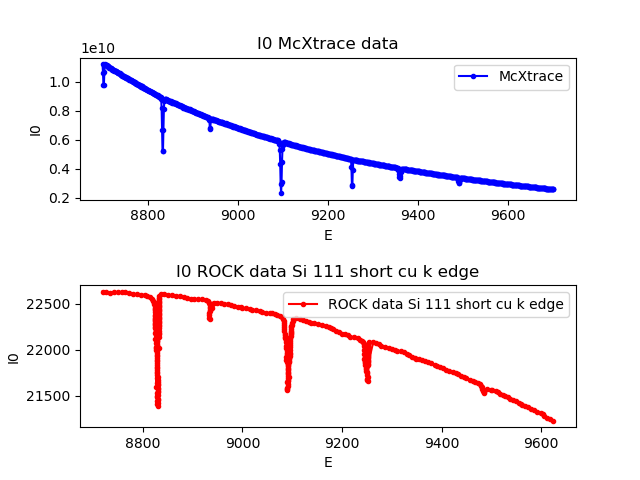

McXtrace and ROCK data plotted.


In [11]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
########### Plot 

########### Ask what to plot
print("Give the atom name and edge you want to plot. Here is the list:")
print("For Si 111 short crystals:")
print("au_l3, co_k, cu_k, fe_k, ir_l3, mn_k, ti_k, ti_k_2, v_k, w_l3, zn_k.")
print("For Si 111 long crystals:")
print("au_l3, co_k, cu_k, fe_k, mn_k, ni_k, v_k.")  
xtal_choice = str(input("long (type 0) or short (1):"))      
material_edge_choice = str(input("Input AtomName_Edge:"))

if xtal_choice==0:
    data_rock_filename = "./data/digitalized_rock_data/si_111_long/si_111_long_"+material_edge_choice+"_edge.txt"
else:
    data_rock_filename = "./data/digitalized_rock_data/si_111_court/si_111_court_"+material_edge_choice+"_edge.txt"

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

########### Get data from digitalized ROCK data.
data_rock = np.loadtxt(data_rock_filename, encoding='utf-8-sig',delimiter=";")
size_data_rock = len(data_rock)
X_rock = np.zeros(size_data_rock)
Y_rock = np.zeros(size_data_rock)

i=0
for elt in data_rock:    
    X_rock[i] = elt[0]
    Y_rock[i] = elt[1]
    i+=1

info_mat_edge = material_edge_choice.split("_")
if xtal_choice=="0":
    info_plot = "Si 111 long " + info_mat_edge[0] + " " +info_mat_edge[1] + " edge"
else:
    info_plot = "Si 111 short " + info_mat_edge[0] + " " +info_mat_edge[1] + " edge"

########### For now only the data for the short cc has been done, so we plot both McXtrace data and ROCK's data if 
#the short cc is selected, otherwise only ROCK's data
figure, axis = plt.subplots(2)
#the scan that was done by the user in this notebook
data_mcxtrace = np.loadtxt("./running_mcxtrace/mcxtrace_rock_111/mccode_mcstasscript_rock_111.dat")
size_data_mcxtrace = len(data_mcxtrace)
X_mcxtrace = np.zeros(size_data_mcxtrace)
Y_mcxtrace = np.zeros(size_data_mcxtrace)
i=0
for elt in data_mcxtrace:
    X_mcxtrace[i] = elt[0]
    Y_mcxtrace[i] = elt[1] #I0
    i+=1

axis[0].plot(X_mcxtrace, Y_mcxtrace, marker='.', color="b", label='McXtrace')
axis[0].legend(fontsize=10)    
axis[0].set_title("I0 McXtrace data")
axis[0].set_xlabel("E")
axis[0].set_ylabel("I0")

axis[1].plot(X_rock, Y_rock, marker='.', color="r", label='ROCK data '+info_plot)
axis[1].legend(fontsize=10)
axis[1].set_title("I0 ROCK data " + info_plot)
axis[1].set_xlabel("E")
axis[1].set_ylabel("I0")

plt.subplots_adjust(hspace=0.6)
plt.show()
print("McXtrace and ROCK data plotted.")

### Prearranged plots <a name="prearranged_plots"></a> 

Here are plots that have been done in advance for the Si 111 short crystal for different energy ranges. Concerning the Si 111 long crystal, the exact orientation of it still needs to be found. When it is, data will come.

#### Some results

Before running the code cell beneath, two energy scans have been run for the crystal Si 111 short from 8700 to 9700 eV for two different sources. One source's range goes from 4 to 40 keV, the other one is centered on the bragg energy the crystal selects with a dE=1eV. 

The energy divergence of the white source is responsible for creating glitches with two dips. The reason has not yet been elucidated, but to avoid this erroneous result, the following plots have been done using the narrow bandwith source of dE=1eV.  

#### ROCK (Si 111 long and short) and McXtrace (Si 111 short) data


Give the atom name and edge you want to plot. Here is the list:
For Si 111 short crystals:
au_l3, co_k, cu_k, fe_k, ir_l3, mn_k, ti_k_2, v_k, w_l3, zn_k.
For Si 111 long crystals:
au_l3, co_k, cu_k, fe_k, mn_k, ni_k, v_k.
long (type 0) or short (1):1
Input AtomName_Edge:v_k


<IPython.core.display.Javascript object>


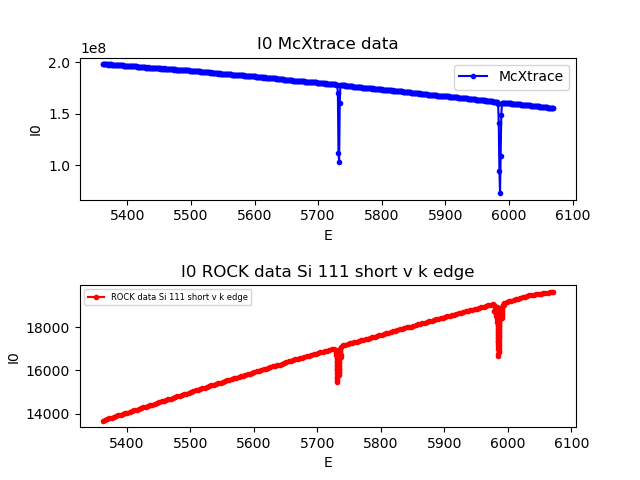

McXtrace and ROCK data plotted.


In [36]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
########### Plot 

########### Ask what to plot
print("Give the atom name and edge you want to plot. Here is the list:")
print("For Si 111 short crystals:")
print("au_l3, co_k, cu_k, fe_k, ir_l3, mn_k, ti_k_2, v_k, w_l3, zn_k.")
print("For Si 111 long crystals:")
print("au_l3, co_k, cu_k, fe_k, mn_k, ni_k, v_k.")
      
xtal_choice = str(input("long (type 0) or short (1):"))      
material_edge_choice = str(input("Input AtomName_Edge:"))

if xtal_choice==0:
    data_rock_filename = "./data/digitalized_rock_data/si_111_long/si_111_long_"+material_edge_choice+"_edge.txt"
else:
    data_rock_filename = "./data/digitalized_rock_data/si_111_court/si_111_court_"+material_edge_choice+"_edge.txt"

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import math as m
########### Get data from digitalized ROCK data.
data_rock = np.loadtxt(data_rock_filename, encoding='utf-8-sig',delimiter=";")
size_data_rock = len(data_rock)
X_rock = np.zeros(size_data_rock)
Y_rock = np.zeros(size_data_rock)

i=0
for elt in data_rock:    
    X_rock[i] = elt[0]
    Y_rock[i] = elt[1]
    i+=1

info_mat_edge = material_edge_choice.split("_")
if xtal_choice=="0":
    info_plot = "Si 111 long " + info_mat_edge[0] + " " +info_mat_edge[1] + " edge"
else:
    info_plot = "Si 111 short " + info_mat_edge[0] + " " +info_mat_edge[1] + " edge"

########### For now only the data for the short cc has been done, so we plot both McXtrace data and ROCK's data if 
#the short cc is selected, otherwise only ROCK's data
if(xtal_choice!="1"):    
    plt.title("I0 ROCK data " + info_plot)
    plt.xlabel("E")
    plt.ylabel("I0")
    plt.plot(X_rock, Y_rock, marker='.', color="r", label='ROCK data '+info_plot)
    plt.legend(fontsize=10)
    plt.show()
    print("ROCK data plotted.")
elif(xtal_choice=="1"):
    figure, axis = plt.subplots(2) 
    data_mcxtrace = np.loadtxt("./data/data_mcxtrace/si_111_short/mccode_"+material_edge_choice+"_edge.dat")
    size_data_mcxtrace = len(data_mcxtrace)
    X_mcxtrace = np.zeros(size_data_mcxtrace)
    Y_mcxtrace = np.zeros(size_data_mcxtrace)
    i=0
    for elt in data_mcxtrace:
        X_mcxtrace[i] = elt[0]
        Y_mcxtrace[i] = elt[1] #I0
        i+=1
        
    #same start(xmin) and end(xmax) for both plots so the x axis aligns
    x_min_rock = float(m.floor(X_rock[0]))
    x_max_rock = float(m.floor(X_rock[-1]))
    pos_x_min_rock, =  np.where(np.isclose(X_mcxtrace, x_min_rock)) 
    pos_x_max_rock, = np.where(np.isclose(X_mcxtrace, x_max_rock)) 
    
    axis[0].plot(X_mcxtrace[pos_x_min_rock[0]:pos_x_max_rock[0]], Y_mcxtrace[pos_x_min_rock[0]:pos_x_max_rock[0]], marker='.', color="b", label='McXtrace')
    axis[0].legend(fontsize=10)
    axis[0].set_title("I0 McXtrace data")
    axis[0].set_xlabel("E")
    axis[0].set_ylabel("I0")

    axis[1].plot(X_rock, Y_rock, marker='.', color="r", label='ROCK data '+info_plot)
    axis[1].legend(fontsize=6)
    axis[1].set_title("I0 ROCK data " + info_plot)
    axis[1].set_xlabel("E")
    axis[1].set_ylabel("I0")
 
    plt.subplots_adjust(hspace=0.6)
    plt.show()
    print("McXtrace and ROCK data plotted.")

###### Theory glitches data (Si 111 short)

Here are the theory glitches found for the Si 111 short crystals.  

Chose an xmin and xmax between 5323 and 18914 eV
Input xmin(integer):5400
Input xmax(integer):6050


<IPython.core.display.Javascript object>


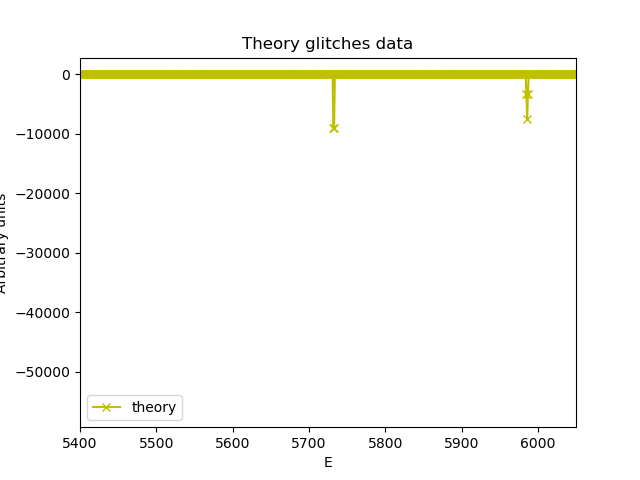

glitches between 5400 eV and 6050 eV are found for the following energies(eV):
 [5732.0, 5733.0, 5985.0, 5986.0, 5987.0]


In [37]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import math as m

########### Get data from theory_itsty_firstxtal.dat, the theory glitches
data_theory_glitches = np.loadtxt("./data/data_from_theory_glitches/Si_111_short/theory_itsty_firstxtal.dat")
size_data_theory_glitches = len(data_theory_glitches)
X_theory_glitches = np.zeros(size_data_theory_glitches)
Y_theory_glitches = np.zeros(size_data_theory_glitches)
i=0

list_of_glitches = []

for elt in data_theory_glitches:
    X_theory_glitches[i] = elt[0]
    Y_theory_glitches[i] = -elt[1]
    if (elt[1]!=0):        
        list_of_glitches.append(elt[0])
    i+=1    

#ask start(xmin) and end(xmax)
print("Chose an xmin and xmax between 5323 and 18914 eV")
x_min =int(input("Input xmin(integer):"))
x_max = int(input("Input xmax(integer):"))
plt.xlim(x_min,x_max)    

#select the glitches in the [xmin,xmax] interval
list_of_glitches_in_interval = []
for elt in list_of_glitches:
    if(elt>=x_min and elt<=x_max):
        list_of_glitches_in_interval.append(elt)
        
plt.plot(X_theory_glitches, Y_theory_glitches, marker='x', color="y", label='theory')
plt.legend(fontsize=10)
plt.title("Theory glitches data")
plt.xlabel("E")
plt.ylabel("Arbitrary units")
plt.show()

print("glitches between "+str(x_min)+" eV and "+str(x_max)+" eV are found for the following energies(eV):\n",list_of_glitches_in_interval)    

###### Theory glitches data animation (Si 111 short)


Here is an animation of the theory glitches between the energies 8251 and 9201 eV, with the azimuthal angle(the angle between the axis parallel to the long side of the crystal and the projection of the beam on the crystal's plane) going from -1 to 1 degrees for the Si 111 short crystals. It can be paused by simply clicking. When pausing on zero degrees, the result is the same as the above.  
It seems like the animation can be run once only in the notebook. If you wish to run it again stop and restart the notebook.

<IPython.core.display.Javascript object>


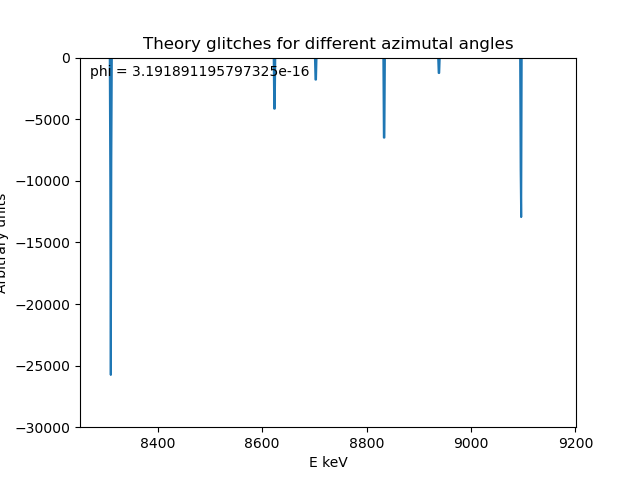

In [38]:
import sys
if './modules' not in sys.path:
    sys.path.append('./modules')

%matplotlib notebook
import theory_glitches_animation_module

# Interpretation <a name="interpretation"></a> 
[[back to toc]](#toc) 

For the Si 111 short crystals, looking at the McXtrace data, the positions of the dips are (mostly) correct. The deviation intensities also.  
For the co_k case, a clear jump in intensity can be observed, this is due to switching to the next coating strip of the harmonics rejection mirror. Separating the scan in two can take care of this issue.  

When it comes to the Si 111 long, it's orientation still needs to be found so the simulation can recreate ROCK's experimental data.    
For the Si 220, there is no ROCK data so the comparison between the simulation and experimental data can not take place.  

Using a narrower source of dE=1eV instead of using the white source of range 4 to 40 keV helped speed up the simulation runtime and improved the monitor's intensity signal.  

## Problems <a name="problems"></a> 
[[back to toc]](#toc)

Using a large source leads to faulty intensity deviations because the statistics are not good enough. It is meant by better statistics that there are more rays of the bragg energy hitting the crystals and being detected in the monitors. This is because the rays emitted by the source are contained in a narrower dE bandwith around the bragg energy. Whereas when the white source is used, the much larger dE bandwith will decrease the density of rays around the bragg energy. When using the white source, the number of rays hitting the principal plane of diffraction is much lower.  

To know more about the above, check the gitlab documentation found [here](https://gitlab.synchrotron-soleil.fr/grades/beamlines/-/tree/main/glitches/deviation_intensity). Older documentation can also be found at the same place.

Using a white source, or even a dE equal to 100eV also leads to glitches being composed of two dips instead of a single dip when using a dE equal to 1eV. This has yet to be explained.  


# Some resources used <a name="resources_used"></a> 
[[back to toc]](#toc)

[hkl plane visualizer](http://ressources.univ-lemans.fr/AccesLibre/UM/Pedago/physique/02/cristallo/planreti.html)

[another hkl plane visualizer](http://lampx.tugraz.at/~hadley/ss1/crystalstructure/structures/diamond/diamond.php)

[Crystallography and reciprocal space video](https://www.youtube.com/watch?v=DFFU39A3fPY)  
 
[Diamond crystal structure](https://web.iitd.ac.in/~ajeetk/AML736/Assignment2_Prob3.pdf) 

"Some considerations on glitches and the design of a double crystal monochromator with bent crystals", P. van Zuylen, M.J. van der Hoek, 248 / SP /E Vol. 733 Soft X -Ray Optics and Technology (1986)

[Old code and documentation preceding this notebook](https://gitlab.synchrotron-soleil.fr/grades/beamlines/-/tree/main/glitches)